In [2]:
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("02_Used_Car_Prices.xlsx")

print(df.shape)
print(df.info())
print(df.head())

df.describe(include="all")

(6019, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand_Model        6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  Price (INR Lakhs)  6019 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 564.4+ KB
None
                        Brand_Model    Location  Year  Kilometers_Driven  \
0            Maruti Wagon R LXI CNG      Mumbai  2010            

,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price (INR Lakhs)
count,6019,6019,6019.000000,6.019000e+03,6019,6019,6019,6017,5983,5983,5977.000000,6.019000e+03
unique,1876,11,NaN,NaN,5,2,4,442,146,372,NaN,NaN
top,Mahindra XUV500 W8 2WD,Mumbai,NaN,NaN,Diesel,Manual,First,18.9 kmpl,1197 CC,74 bhp,NaN,NaN
freq,49,790,NaN,NaN,3205,4299,4929,172,606,235,NaN,NaN
mean,NaN,NaN,2013.358199,5.873838e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.278735,9.479468e+05
std,NaN,NaN,3.269742,9.126884e+04,NaN,NaN,NaN,NaN,NaN,NaN,0.808840,1.118792e+06
min,NaN,NaN,1998.000000,1.710000e+02,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,4.400000e+04
25%,NaN,NaN,2011.000000,3.400000e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,3.500000e+05
50%,NaN,NaN,2014.000000,5.300000e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,5.640000e+05
75%,NaN,NaN,2016.000000,7.300000e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,9.950000e+05


In [7]:
df.isnull().sum().sort_values(ascending=False)

Seats                42
Engine               36
Power                36
Mileage               2
Brand_Model           0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Price (INR Lakhs)     0
dtype: int64

For Power, `df["Power"] = df["Power"].replace(["null bhp", "bhp", "", " "], np.nan)` converts junk placeholders (like the “null bhp”, a value that’s only “bhp”, or empty/space-only cells) into true missing values (`NaN`). Then `df["Power_bhp"] = df["Power"].str.extract(r"([\d.]+)").astype(float)` uses a regex to grab the first numeric chunk (e.g., “103.5” from “103.5 bhp”) and casts it to `float`, to get a clean power column. rows without a valid number stay `NaN`. For Engine, `df["Engine"] = df["Engine"].replace(["", " ", "null cc"], np.nan)` does the same missing value cleanup (treating blanks or “null cc” as `NaN`), and `df["Engine_cc"] = df["Engine"].str.extract(r"([\d.]+)").astype(float)` pulls out the numeric displacement (e.g., “1497” from “1497 CC”) and converts it to a numeric `Engine_cc` feature.

In [8]:
import numpy as np
import re
# Replace null bhp, bhp, blanks with NaN
df["Power"] = df["Power"].replace(["null bhp", "bhp", "", " "], np.nan)

# Extract numeric part
df["Power_bhp"] = df["Power"].str.extract(r"([\d.]+)").astype(float)


In [9]:
df["Engine"] = df["Engine"].replace(["", " ", "null cc"], np.nan)
df["Engine_cc"] = df["Engine"].str.extract(r"([\d.]+)").astype(float)


This standardizes the Mileage column into a single numeric feature in km per litre (kmpl). The helper `normalize_mileage(raw)` first treats missing entries as `NaN`. For non missing rows, it uses a regex to extract the numeric part (e.g., `"19.67 kmpl"`to `19.67`, `"26.6 km/kg"` to `26.6`), converts that to `float`, then lowercases the original string to inspect the unit. If the text contains `"km/kg"` (typical for CNG), it multiplies the value by 1.3 as a conversion to an equivalent kmpl scale, otherwise it returns the number as is (already kmpl). Applying this with `df["Mileage"].apply(normalize_mileage)` creates a clean numeric column `Mileage_kmpl`. Finally, `df.loc[df["Mileage_kmpl"] == 0, "Mileage_kmpl"] = np.nan` replaces any zero mileages which usually indicate missing/invalid entries rather than true zero fuel economy with `NaN` 

In [10]:
def normalize_mileage(raw):
    if pd.isna(raw): 
        return np.nan
    m = re.search(r"[\d.]+", str(raw))
    if not m:
        return np.nan
    val = float(m.group())
    s = str(raw).lower()
    if "km/kg" in s:   
        return val * 1.3
    return val         

df["Mileage_kmpl"] = df["Mileage"].apply(normalize_mileage)

# Replace 0.0 with NaN 
df.loc[df["Mileage_kmpl"] == 0, "Mileage_kmpl"] = np.nan


First, df.loc[df["Seats"] == 0, "Seats"] = np.nan flags any cars recorded with 0 seats as missing (NaN), because that’s not a valid seat count and almost always means unknown/erroneous. Next, df = df.drop(columns=["Power", "Engine", "Mileage"]) deletes the original text columns after you’ve already created their clean numeric versions (Power_bhp, Engine_cc, Mileage_kmpl). Dropping them avoids confusion and double counting

In [11]:
df.loc[df["Seats"] == 0, "Seats"] = np.nan

In [12]:
df = df.drop(columns=["Power", "Engine", "Mileage"])

In [13]:
df.isnull().sum().sort_values(ascending=False)

Power_bhp            143
Mileage_kmpl          70
Seats                 43
Engine_cc             36
Brand_Model            0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Price (INR Lakhs)      0
dtype: int64

it replaces NaNs with the median of that column (power_bhp, Engine_cc, Mileage_kmpl, and Seats). The median is chosen because it’s robust to outliers (e.g., a few very high-bhp cars or extreme mileages won’t skew it like the mean would). After earlier cleaning (e.g., converting units, removing 0 mileage, fixing seat=0), these fills ensure models don’t drop rows or fail on nulls. 

In [14]:
df["Power_bhp"].fillna(df["Power_bhp"].median(), inplace=True)
df["Engine_cc"].fillna(df["Engine_cc"].median(), inplace=True)
df["Mileage_kmpl"].fillna(df["Mileage_kmpl"].median(), inplace=True)
df["Seats"].fillna(df["Seats"].median(), inplace=True)

In [15]:
df.isnull().sum().sort_values(ascending=False)

Brand_Model          0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Seats                0
Price (INR Lakhs)    0
Power_bhp            0
Engine_cc            0
Mileage_kmpl         0
dtype: int64

This creates a new column called brand by splitting the brand_model column

In [16]:
df["Brand"] = df["Brand_Model"].astype(str).str.split().str[0]

In [17]:
df.rename(columns={"Price (INR Lakhs)": "Price"}, inplace=True)

In [18]:
df["Price"] = df["Price"] / 100000

The price distribution is strongly right skewed, with most cars concentrated in the lower to mid ranges and a long tail created by a small number of very expensive listings (likely luxury models or outliers) stretching far to the right. The density peak sits roughly around 3–15 Lakhs, indicating that’s where the bulk of transactions lie because of the heavy upper tail, the mean price will sit above the median.

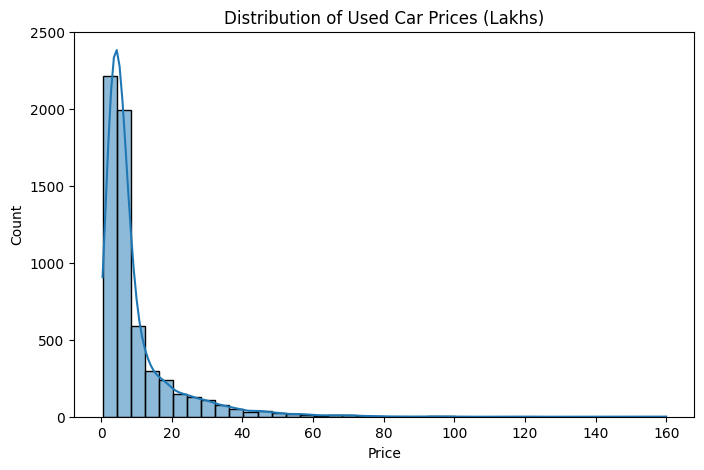

In [19]:
# Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df["Price"], bins=40, kde=True)
plt.title("Distribution of Used Car Prices (Lakhs)")
plt.show()

the histogram is showing the number of listed used cars by model year. there is almost none from the late ’90s/early 2000s, a steady rise through the late 2000s, and a big concentration around 2012–2016, then fewer cars from 2017–2019 likely because very new cars haven’t yet cycled into the used market and the dataset cuts off

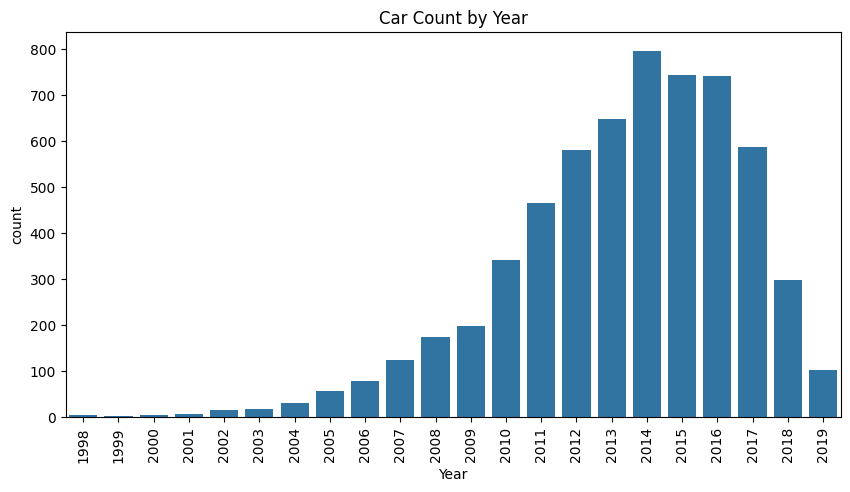

In [20]:
# Year distribution
plt.figure(figsize=(10,5))
sns.countplot(x="Year", data=df, order=sorted(df["Year"].unique()))
plt.xticks(rotation=90)
plt.title("Car Count by Year")
plt.show()

This removes those rows where kilometers_driven are more than 500000 because it is very unlikely for the kilometers_driven to be higher than 500000.

In [21]:
df = df[df["Kilometers_Driven"] < 500000]

The chart shows it is more rightskewed so most used cars cluster roughly in the 40–90k km range (peak around 60k), with a long tail past 100k–200k km and a handful of extreme values approaching 300–500k km. Those ultra high readings are either very high mileage vehicles or potential data errors worth flagging

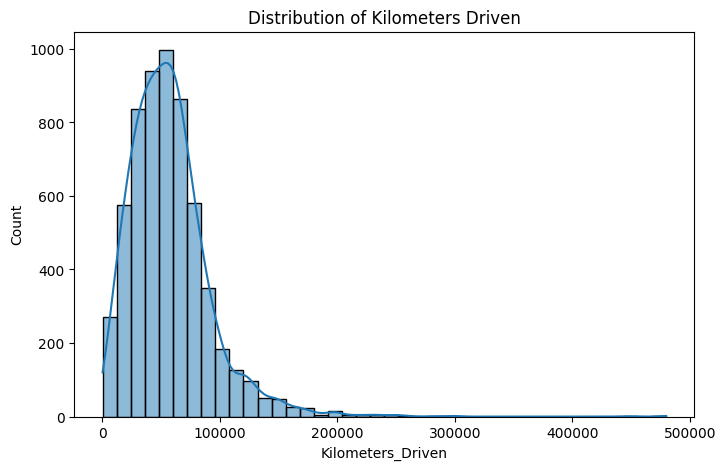

In [22]:
# Kilometers driven
plt.figure(figsize=(8,5))
sns.histplot(df["Kilometers_Driven"], bins=40, kde=True)
plt.title("Distribution of Kilometers Driven")
plt.show()


The mileage (kmpl) distribution is centered around 17–20 kmpl with most cars falling between about 12 and 25 kmpl. There’s a light right tail with a small number of very high values 35–43 kmpl, which are likely highly efficient CNG/diesel entries  On the low end 10 kmpl are larger/older engines or city cycle ratings.


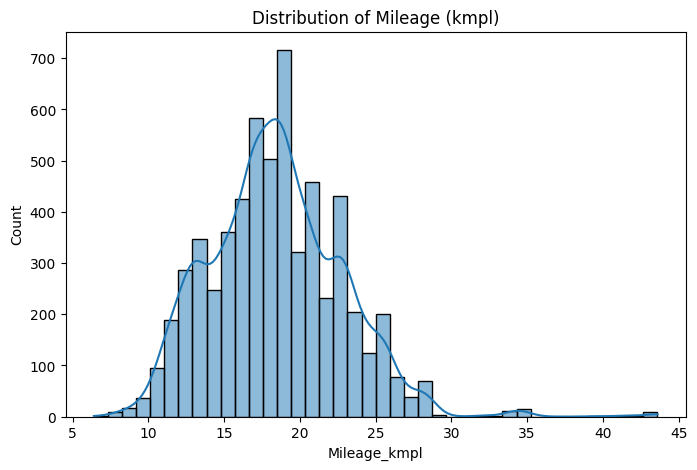

In [23]:
# Mileage
plt.figure(figsize=(8,5))
sns.histplot(df["Mileage_kmpl"], bins=40, kde=True)
plt.title("Distribution of Mileage (kmpl)")
plt.show()


The boxplots show a clear upward trend in price with newer model years where medians steadily rise from the early 2000s to 2019, and the spread (IQR and whiskers) widens for recent years. That wider spread reflects greater trim/segment variety (hatchbacks to premium SUVs) and less depreciation variability among newer cars. Older years have low, tightly clustered prices with few high outliers, while newer years include many high end outliers, consistent with luxury models holding value.

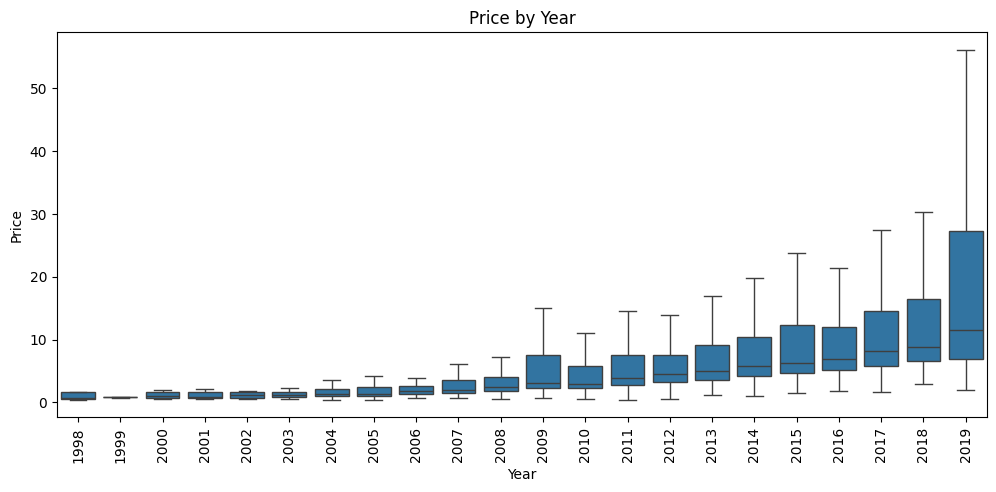

In [24]:
# Price vs Year
plt.figure(figsize=(12,5))
sns.boxplot(x="Year", y="Price", data=df, showfliers=False)
plt.xticks(rotation=90)
plt.title("Price by Year")
plt.show()

Diesel cars are the priciest and most variable where their median is higher than petrol  (around 8 vs. around 4–5 Lakhs) and the spread is huge, with many expensive outliers (SUVs/premiums) reaching >30 Lakhs. Petrol sits mid range with a tighter spread. CNG and LPG are the cheapest, clustered around 2–3 Lakhs, which fits their typical use in older, budget city cars. Electric shows a high median (around 13 Lakhs) but an unusually narrow box likely a very small sample (few models/years)

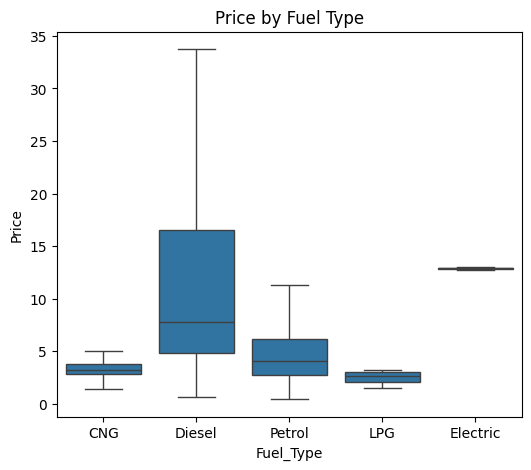

In [25]:
# Price vs Fuel_Type
plt.figure(figsize=(6,5))
sns.boxplot(x="Fuel_Type", y="Price", data=df, showfliers=False)
plt.title("Price by Fuel Type")
plt.show()

Automatic cars are pricier where the median price for automatic is far above manual, and the spread is much wider, with many high end outliers (into the 30–50+ Lakhs range). Manual cars cluster tightly at the lower end (roughly 3–7 Lakhs), reflecting older or budget segments.

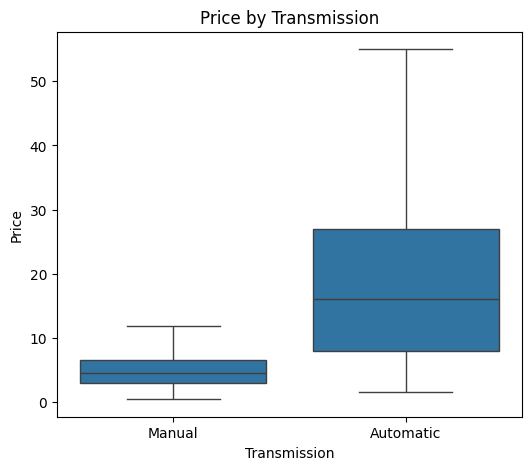

In [26]:
# Price vs Transmission
plt.figure(figsize=(6,5))
sns.boxplot(x="Transmission", y="Price", data=df, showfliers=False)
plt.title("Price by Transmission")
plt.show()

The scatter shows a weak to moderate negative relationship between fuel efficiency (kmpl) and price. High priced cars cluster at lower kmpl (≈8–16) typical of larger, more powerful models while very efficient cars (30–40+ kmpl) are almost all low priced budget/CNG/diesel entries. Most listings sit in the 12–22 kmpl band with prices under around 15 Lakhs, indicating mileage alone doesn’t drive price it’s confounded by segment/engine size, fuel type and year.

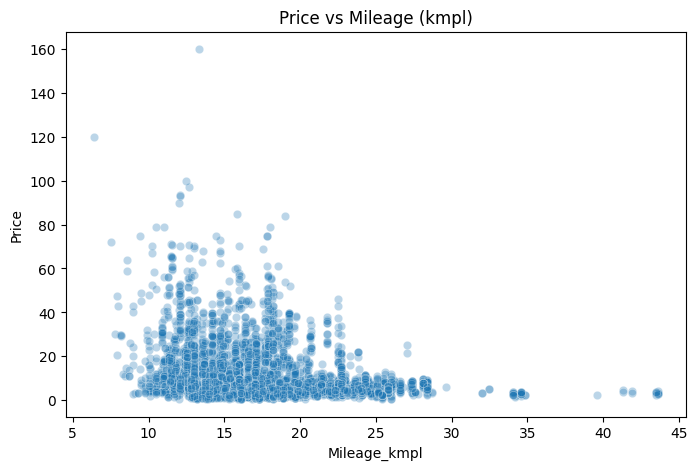

In [27]:
# Price vs Mileage
plt.figure(figsize=(8,5))
sns.scatterplot(x="Mileage_kmpl", y="Price", data=df, alpha=0.3)
plt.title("Price vs Mileage (kmpl)")
plt.show()

The heatmap shows power and engine size are the strongest linear drivers of price where Power_bhp (around 0.77) and Engine_cc (around 0.66)
correlate positively with Price, while Year has a smaller positive link (around 0.30). Price falls as Mileage_kmpl rises (around -0.32) and as Kilometers_Driven increases (around −0.18)

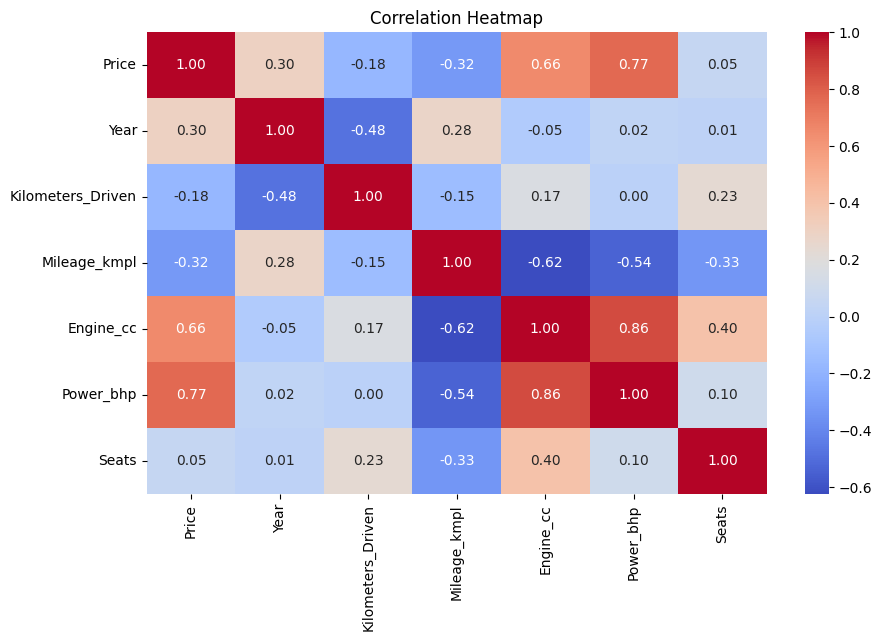

In [28]:
plt.figure(figsize=(10,6))
corr_cols = ["Price","Year","Kilometers_Driven","Mileage_kmpl","Engine_cc","Power_bhp","Seats"]
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Premium brands dominate the averages where Mercedes Benz, BMW, and Audi sit at the top (25–27 Lakhs), reflecting luxury segments and newer model years. Toyota and Mahindra land mid range (8–12 Lakhs), while mass market brands like Maruti, Hyundai, Honda, and Volkswagen cluster lower (5–6 Lakhs). Ford is slightly above the lower cluster (7 Lakhs).

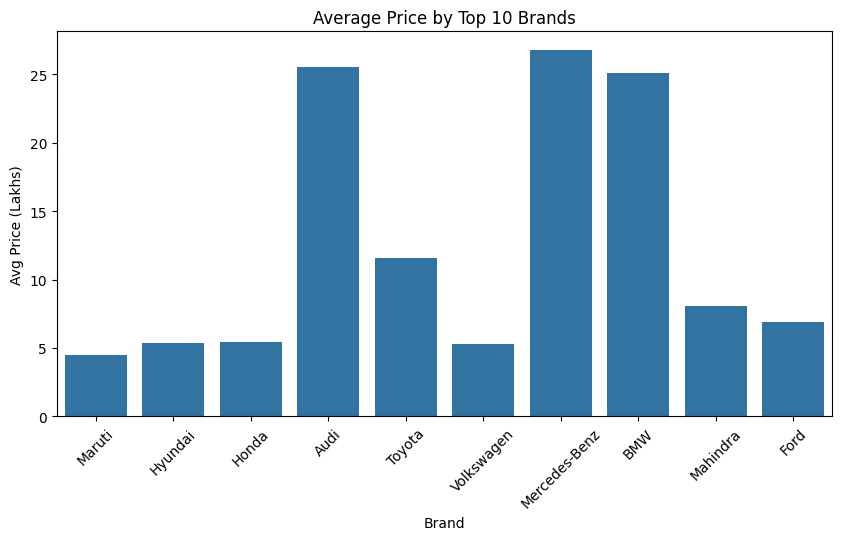

In [29]:
# Avg price by top 10 brands
top_brands = df["Brand"].value_counts().nlargest(10).index
plt.figure(figsize=(10,5))
sns.barplot(data=df[df["Brand"].isin(top_brands)], x="Brand", y="Price", estimator=np.mean, errorbar=None)
plt.title("Average Price by Top 10 Brands")
plt.ylabel("Avg Price (Lakhs)")
plt.xticks(rotation=45)
plt.show()

Average prices vary a lot by city where Coimbatore and Bangalore sit at the top (13–15 Lakhs), followed by Kochi and Mumbai (11–12 and 9–10 Lakhs), while Jaipur and Kolkata are lower (around 6 Lakhs). This likely reflects each city’s mix of segments and model years (e.g., more SUVs/premium cars in some markets), overall demand, and sample sizes not just a pure “location effect.” 

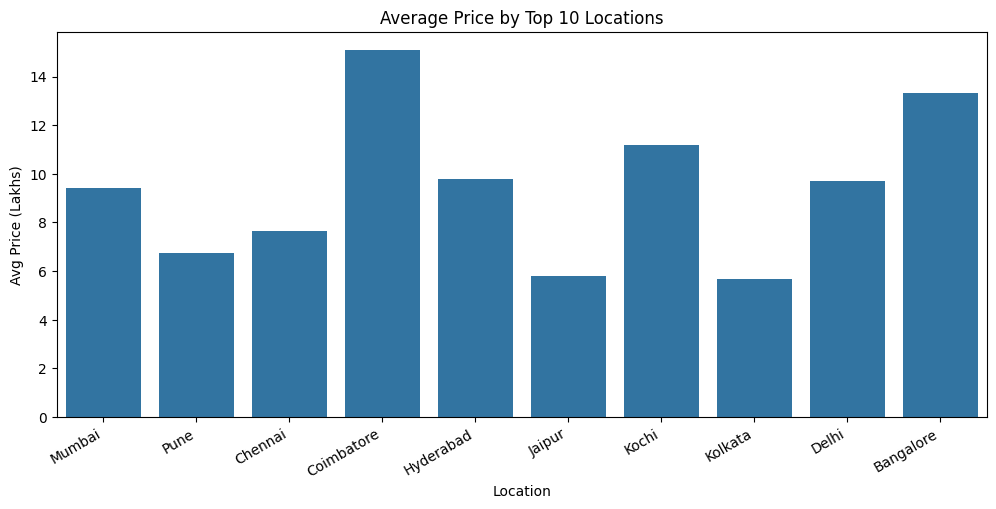

In [30]:
# Avg price by top 10 locations
top_locs = df["Location"].value_counts().nlargest(10).index
plt.figure(figsize=(12,5))
sns.barplot(data=df[df["Location"].isin(top_locs)], x="Location", y="Price", estimator=np.mean, errorbar=None)
plt.xticks(rotation=30, ha="right")
plt.title("Average Price by Top 10 Locations")
plt.ylabel("Avg Price (Lakhs)")
plt.show()

**TASK 2**

In [31]:
from pycaret.regression import *
reg = setup(
    data=df,
    target="Price",          
    train_size=0.8,          
    fold=5,                  # 5 fold CV
    normalize=True,         
    log_experiment=True, 
    experiment_name="used_car_prices",
    session_id=42,
    verbose=True
)



,Description,Value
0,Session id,42
1,Target,Price
2,Target type,Regression
3,Original data shape,"(6015, 13)"
4,Transformed data shape,"(6015, 30)"
5,Transformed train set shape,"(4812, 30)"
6,Transformed test set shape,"(1203, 30)"
7,Numeric features,6
8,Categorical features,6
9,Preprocess,True


The `compare_models()` results show that KNN gives the strongest overall fit, with the highest R^2 (0.75) and lowest RMSE (5.61 Lakhs), so PyCaret selects it as best by default. CatBoost has the lowest MAE (2.06 Lakhs), meaning its typical errors are smallest, but its RMSE/R^2 are slightly worse than KNN so it likely makes a few bigger mistakes that inflate RMSE. Tree ensembles like GBR/XGBoost/LightGBM sit in the middle, while linear models trail, suggesting the price signal is non linear and benefits from flexible learners. The Dummy baseline’s very poor scores confirms the model adds substantial value.

In [32]:
best = compare_models()    
pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,2.3747,32.1764,5.6096,0.7501,0.2833,0.2697,0.0720
catboost,CatBoost Regressor,2.0587,33.1040,5.6589,0.7441,0.2929,0.2730,1.1420
gbr,Gradient Boosting Regressor,2.5936,37.5420,6.0444,0.7093,0.3701,0.4025,0.2020
xgboost,Extreme Gradient Boosting,2.3151,39.1220,6.1573,0.6978,0.3404,0.3230,0.1160
et,Extra Trees Regressor,2.3551,39.3479,6.1888,0.6957,0.3404,0.3289,0.4260
en,Elastic Net,3.1438,39.4763,6.2359,0.6929,0.4095,0.4789,0.0600
huber,Huber Regressor,3.0571,39.6849,6.2454,0.6917,0.4229,0.4815,0.0720
lightgbm,Light Gradient Boosting Machine,2.4291,40.2045,6.2600,0.6884,0.3611,0.3615,0.1940
br,Bayesian Ridge,3.5222,41.8308,6.4229,0.6741,0.4722,0.6317,0.0600
ridge,Ridge Regression,3.5287,41.9480,6.4319,0.6731,0.4730,0.6333,0.0640


2025/08/26 14:05:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/26 14:05:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/26 14:05:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/26 14:05:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/26 14:05:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/26 14:05:56 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,2.3747,32.1764,5.6096,0.7501,0.2833,0.2697,0.072
catboost,CatBoost Regressor,2.0587,33.1040,5.6589,0.7441,0.2929,0.2730,1.142
gbr,Gradient Boosting Regressor,2.5936,37.5420,6.0444,0.7093,0.3701,0.4025,0.202
xgboost,Extreme Gradient Boosting,2.3151,39.1220,6.1573,0.6978,0.3404,0.3230,0.116
et,Extra Trees Regressor,2.3551,39.3479,6.1888,0.6957,0.3404,0.3289,0.426
en,Elastic Net,3.1438,39.4763,6.2359,0.6929,0.4095,0.4789,0.060
huber,Huber Regressor,3.0571,39.6849,6.2454,0.6917,0.4229,0.4815,0.072
lightgbm,Light Gradient Boosting Machine,2.4291,40.2045,6.2600,0.6884,0.3611,0.3615,0.194
br,Bayesian Ridge,3.5222,41.8308,6.4229,0.6741,0.4722,0.6317,0.060
ridge,Ridge Regression,3.5287,41.9480,6.4319,0.6731,0.4730,0.6333,0.064


Tuning helped improve the model. If we compare it with the pre tune KNN (MAE=2.37, RMSE=5.61, R^2= 0.75), the tuned model averages MAE=2.32, RMSE=5.42, and R^2=0.77, with lower RMSLE/MAPE too. So errors are smaller and the fit is stronger. The fold results show some variability (R^2 std =0.044) where folds 3–4 perform much better (R^2 =0.84/0.80, RMSE =4.41/4.66), while folds 1–2 are weaker, suggesting the data has segments that are easier/harder to predict (e.g., certain brands/years/locations).

In [33]:
tuned = tune_model(best)
evaluate_model(tuned)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.4326,33.6642,5.8021,0.7614,0.2729,0.2714
1,2.2936,36.4650,6.0386,0.7307,0.2677,0.2696
2,2.5079,38.2226,6.1824,0.7142,0.2830,0.2654
3,2.1851,19.4217,4.4070,0.8354,0.2689,0.2577
4,2.1635,21.6722,4.6553,0.7967,0.2731,0.2597
Mean,2.3165,29.8892,5.4171,0.7677,0.2731,0.2648
Std,0.1351,7.7978,0.7377,0.0440,0.0054,0.0054


Fitting 5 folds for each of 10 candidates, totalling 50 fits


2025/08/26 14:06:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [34]:
final_model = finalize_model(tuned)

holdout_results = predict_model(final_model)   
holdout_results.head()


2025/08/26 14:06:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.8947,15.2748,3.9083,0.8677,0.2275,0.2203


,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Power_bhp,Engine_cc,Mileage_kmpl,Brand,Price,prediction_label
319,Tata Indigo LS Dicor,Pune,2008,138000,Diesel,Manual,Second,5.0,70.000000,1396.0,17.100000,Tata,1.25,2.43625
4890,Hyundai i20 Sportz Diesel,Ahmedabad,2010,62000,Diesel,Manual,First,5.0,90.000000,1396.0,23.000000,Hyundai,2.70,4.13750
3104,Maruti Swift VDI BSIV,Kolkata,2013,41300,Diesel,Manual,First,5.0,97.699997,1248.0,17.799999,Maruti,3.38,3.41000
5524,Mercedes-Benz New C-Class C 200 Kompressor Ele...,Chennai,2010,34000,Petrol,Manual,First,5.0,178.000000,1796.0,11.700000,Mercedes-Benz,10.00,8.65500
84,Maruti Ritz VDi,Jaipur,2013,99638,Diesel,Manual,First,5.0,73.940002,1248.0,23.200001,Maruti,3.11,4.23000


In [35]:
save_model(final_model, "used_car_price_pipeline")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Year', 'Kilometers_Driven',
                                              'Seats', 'Power_bhp', 'Engine_cc',
                                              'Mileage_kmpl'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Brand_Model', 'Location',
                                              'Fuel_Type', 'Transmission',
                                              'Owner_Type', 'Brand'],
                                     transformer=SimpleImputer(...
                                                               handle_missing='return_nan',
                                                               use_cat_names=True))),
                 ('rest_encoding',
                  TransformerWrapper(include=['Brand_Model', 'Brand'],
                        